In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import seaborn
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
import datetime
from pandas_datareader import data as pdr

In [ ]:
#iterating over all pairs of stocks and calculating respetive cointegration
def find_cointegrated_pairs(data):
  n = data.shape[1]
  score_matrix = np.zeros((n,n))
  pvalue_matrix = np.ones((n,n))
  keys = data.keys()
  pairs = []
  for i in range (n):
    for j in range (i+1,n):
      s1 = data[keys[i]]
      s2 = data[keys[j]]
      result = coint(s1,s2)
      score = result[0]
      p_val = result[1]
      score_matrix[i,j] = score
      pvalue_matrix[i,j] = p_val
      if p_val<0.05:
        pairs.append((keys[i],keys[j]))
  return score_matrix,pvalue_matrix,pairs

In [ ]:
start = datetime.datetime(2017,1,1)
end = datetime.datetime(2023,1,1)
tickers = ['TSLA','GM','F','TM','VWAGY','HMC','BMWYY','HMC','HYMTF','NSANY','RACE']
df = yf.download(tickers,start,end)['Adj Close'] #taking close values of all ticker symbols
df.head(15)

[*********************100%%**********************]  10 of 10 completed


,BMWYY,F,GM,HMC,HYMTF,NSANY,RACE,TM,TSLA,VWAGY
Date,,,,,,,,,,
2017-01-03,21.929142,9.082817,30.369263,25.722597,41.000000,20.250000,55.978439,118.550003,14.466000,11.470794
2017-01-04,21.845760,9.501248,32.045395,26.634748,41.000000,20.629999,56.424828,121.190002,15.132667,11.436127
2017-01-05,22.116745,9.212675,31.440617,26.634748,41.000000,20.549999,56.377335,120.440002,15.116667,11.651830
2017-01-06,22.095901,9.205462,31.095015,26.469692,41.000000,20.260000,55.978439,120.129997,15.267333,11.569016
2017-01-09,21.929142,9.111675,31.112291,26.434940,40.200001,20.170000,55.351608,119.739998,15.418667,12.067829
2017-01-10,21.922192,9.270390,32.270039,26.148270,40.200001,20.320000,56.016430,119.760002,15.324667,12.117903
2017-01-11,22.040314,9.140533,32.788433,26.217766,41.500000,20.190001,56.424828,119.910004,15.315333,12.609014
2017-01-12,21.713737,9.082817,32.408279,26.200394,41.500000,20.200001,56.301357,119.639999,15.306000,12.465724
2017-01-13,21.567825,9.111675,32.261402,26.130896,41.500000,20.150000,56.823727,119.809998,15.850000,12.352865


[('GM', 'VWAGY'), ('HMC', 'HYMTF')]


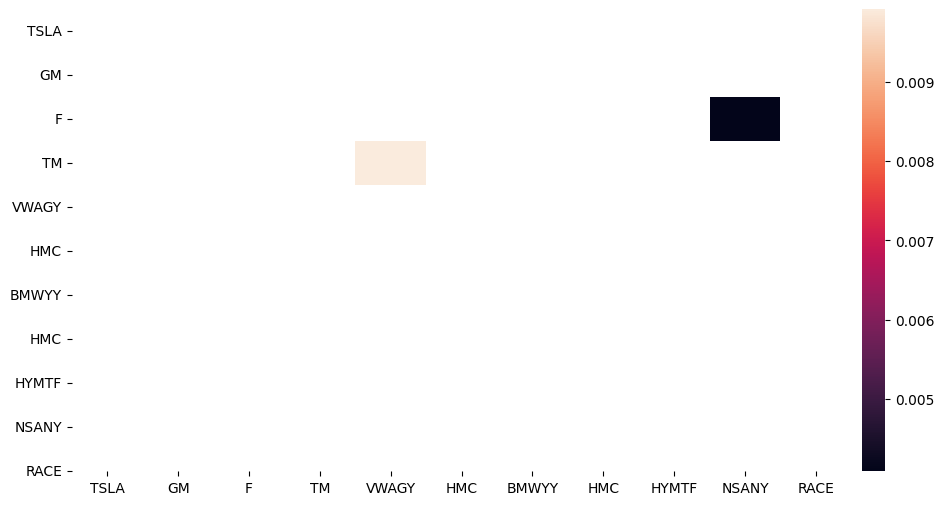

In [ ]:
scores,p_vals,pairs = find_cointegrated_pairs(df)
seaborn.heatmap(p_vals,xticklabels=tickers,yticklabels=tickers, mask=(p_vals>=0.05))
print(pairs)

The heatmap shows two pairs - (Honda,Hyundai) and (General Motors,Volkswagen) to be cointegrated

In [ ]:
s1 = df['GM']
s2 = df['VWAGY']
score,p_val,_ = coint(s1,s2)
p_val

0.004089813768998123

General Motors and Volkswagen have lowest p value denoting maximum cointegration

Estimate coefficients of linear relationship between the two variables. GM(independent variable)

In [ ]:
s1 = sm.add_constant(s1)
results = sm.OLS(s2,s1).fit()
s1

,const,GM
Date,,
2017-01-03,1.0,30.369263
2017-01-04,1.0,32.045395
2017-01-05,1.0,31.440617
2017-01-06,1.0,31.095015
2017-01-09,1.0,31.112291
...,...,...
2022-12-23,1.0,33.566921
2022-12-27,1.0,33.060886
2022-12-28,1.0,32.277031


Slope of the equation

In [ ]:
s1 = s1['GM']
b = results.params['GM']
b

0.46480105514300485

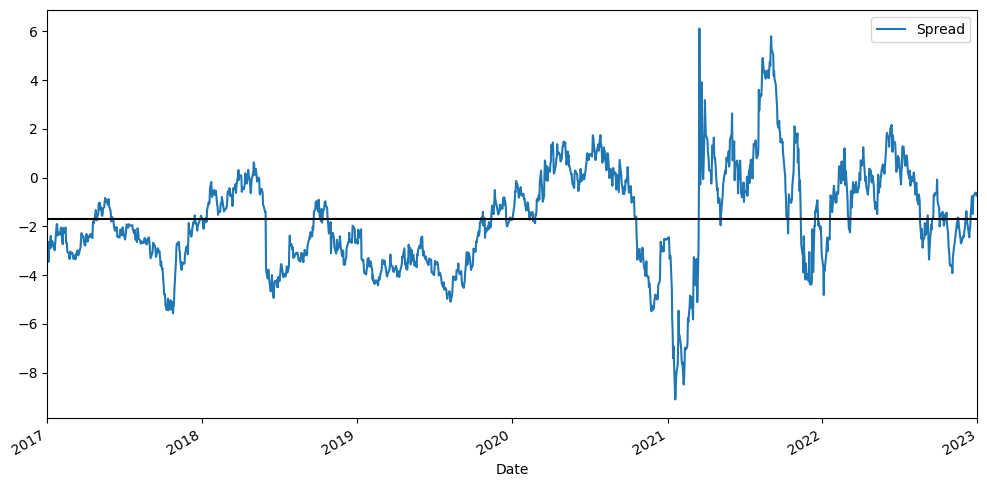

In [ ]:
#calculating the residual error term(spread) by ignoring the y intercept
spread = (s2-b*s1)
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(),color='black')
plt.xlim('2017-01-01','2023-01-01')
plt.legend(['Spread'])

The series revolves around a constan mean suggesting stationarity. Thus this also proves that the series are co-integrated(Engle-Granger Test)

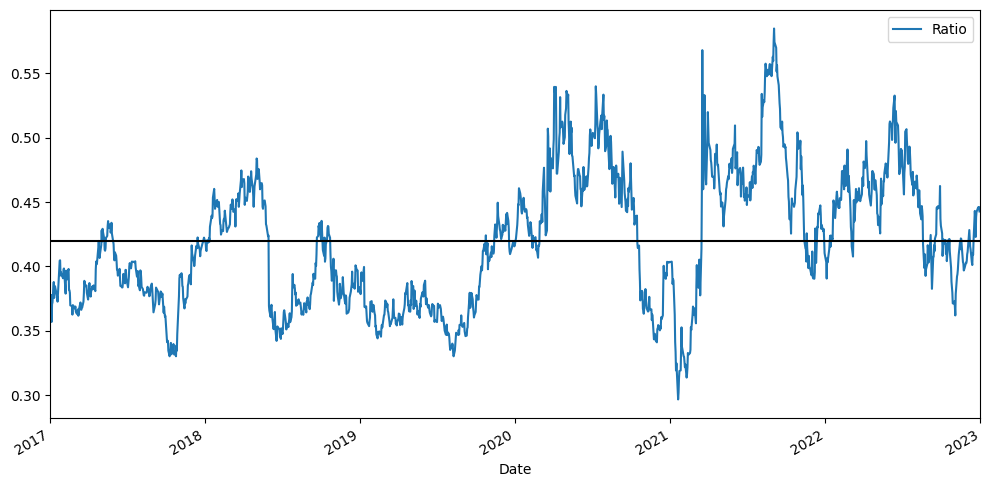

In [ ]:
# plotting ratio plot
ratio = (s2/s1)
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(),color='black')
plt.xlim('2017-01-01','2023-01-01')
plt.legend(['Ratio'])

Trading Strategy

When should be generate "BUY" and "SELL" signals?

Here the trick is to normalize the spread or ratio values. Absolute values might not be the best way to proceed

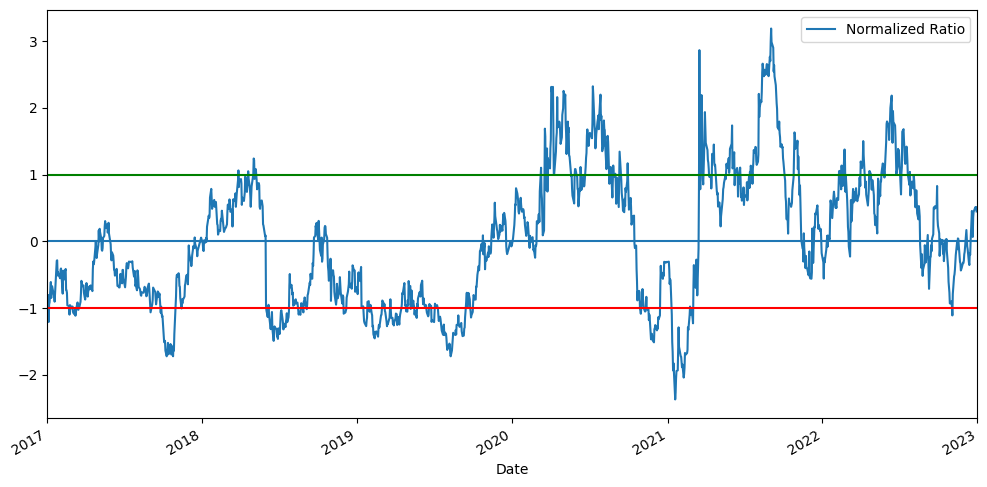

In [ ]:
# z-score of series ratio
def z_score(series):
  return ((series-series.mean())/np.std(series))

z_score(ratio).plot(figsize=(12,6))
plt.axhline(z_score(ratio).mean())
plt.axhline(1.0,color='green')
plt.axhline(-1.0,color='red')
plt.xlim('2017-01-01','2023-01-01')
plt.legend(['Normalized Ratio'])

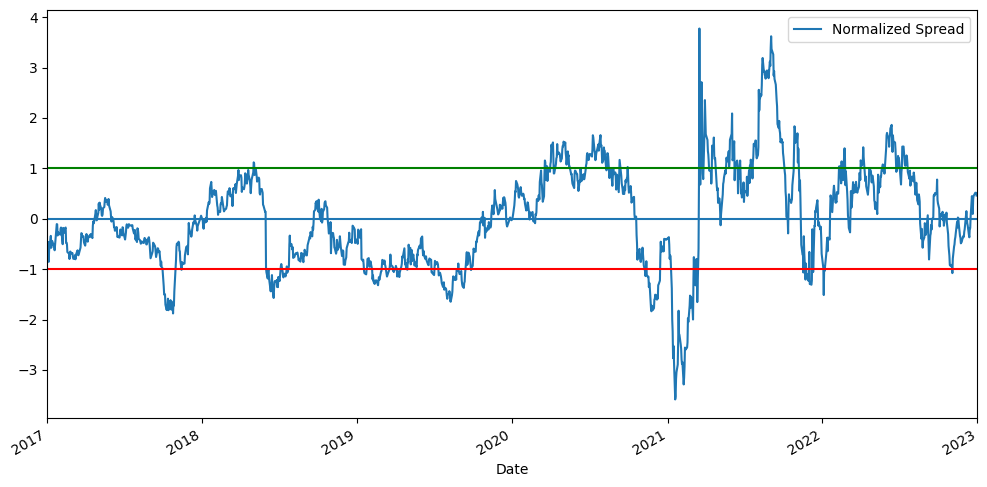

In [ ]:
# z-score of series spread
def z_score(series):
  return ((series-series.mean())/np.std(series))

z_score(spread).plot(figsize=(12,6))
plt.axhline(z_score(ratio).mean())
plt.axhline(1.0,color='green')
plt.axhline(-1.0,color='red')
plt.xlim('2017-01-01','2023-01-01')
plt.legend(['Normalized Spread'])

Both the curves look nearly identical. In many cases, when we calculate the spread (as in the Engle-Granger method without the intercept), it effectively accounts for any constant offset or level difference between the two time series. The ratio method also implicitly accounts for this offset because when you divide one time series by another, you are essentially removing a constant factor.

Spread-based trading is simpler and more intuitive but may not always be as effective if the spread's mean-reversion properties are not consistent.
Ratio-based trading may provide more flexibility in capturing relative performance, hence we will use ratio here.

In [ ]:
ratio = df['VWAGY']/df['GM']
print(len(ratio)*0.7)

1057.0


In [ ]:
train = ratio[:1057]
test = ratio[1057:]

Predictions using Ratio

We need to know what features are significant for determining he direction of trades. Since the ratio lot eventually reverts back to mean, Moving Averages startegy might work

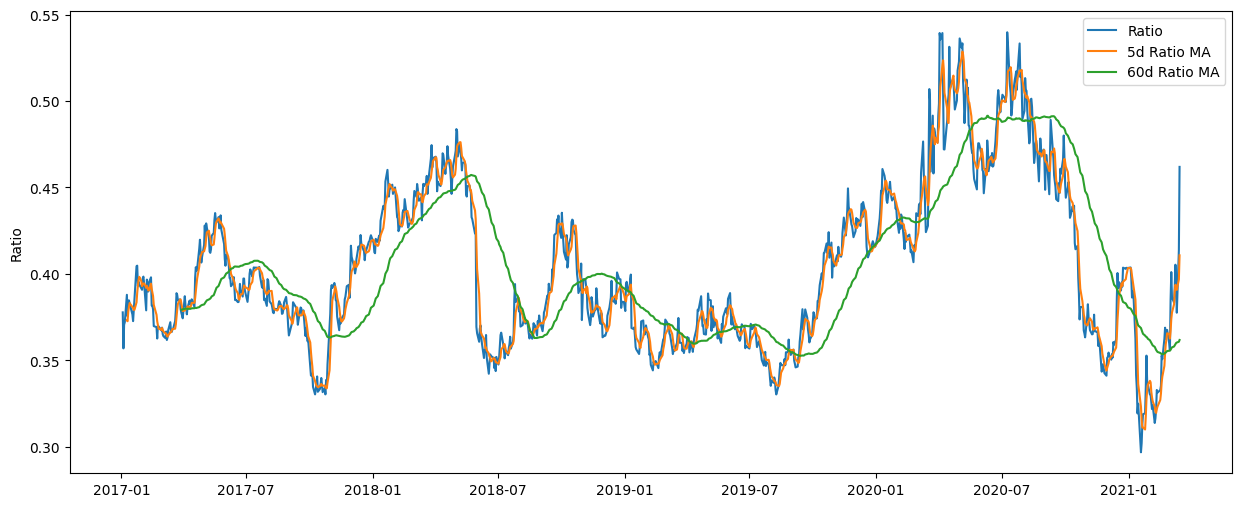

In [ ]:
#considering weekly moving average
ma5_ratio = train.rolling(window=5,center=False).mean()
#3 month moving average
ma60_ratio = train.rolling(window=60,center=False).mean()
#standard deviation of 60 days
std_60 = train.rolling(window=60,center=False).std()
zscore_60_5 = (ma5_ratio - ma60_ratio)/std_60
plt.figure(figsize=(15,6))
plt.plot(train.index, train.values)
plt.plot(ma5_ratio.index, ma5_ratio.values)
plt.plot(ma60_ratio.index, ma60_ratio.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

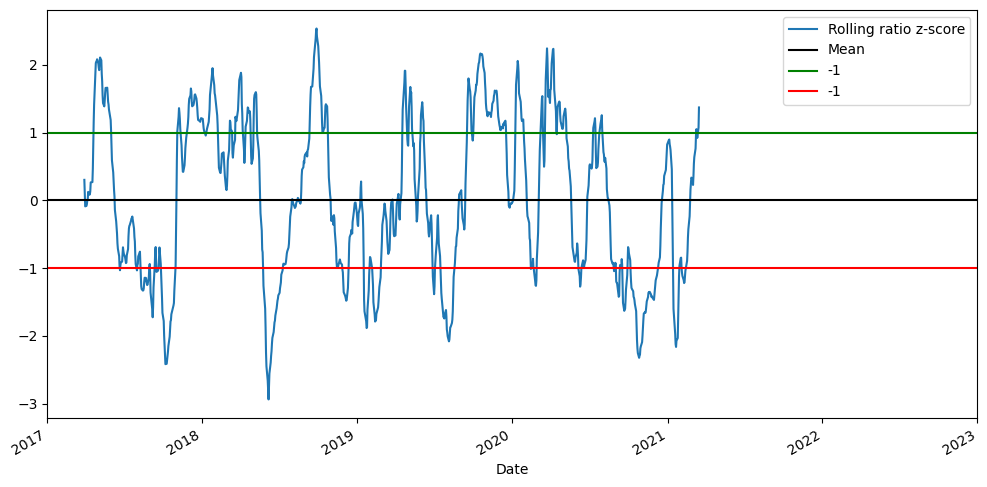

In [ ]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.axhline(0,color='black')
plt.axhline(1.0,color='green')
plt.axhline(-1.0,color='red')
plt.xlim('2017-01-01','2023-01-01')
plt.legend(['Rolling ratio z-score','Mean','-1','-1'])
plt.show()

A standard normal distribution has a mean of 0 and standard deviation of 1. Lookingat the plot, it is clear that the time series when moves beyon 1 or -1, reverts back to its mean.

Hence when the z score is above 1, the ratio decreases that means we should sell(go short)
When the z score is beyong -1, the ratio increases, that means we can buy(go long)

When we buy the ratio, that means the price of stock 2 goes up, hence we should buy the stock 2, eventually the price of stock 1 will go down, so sell stock 2
<br>
Vice-versa for when we sell the ratio

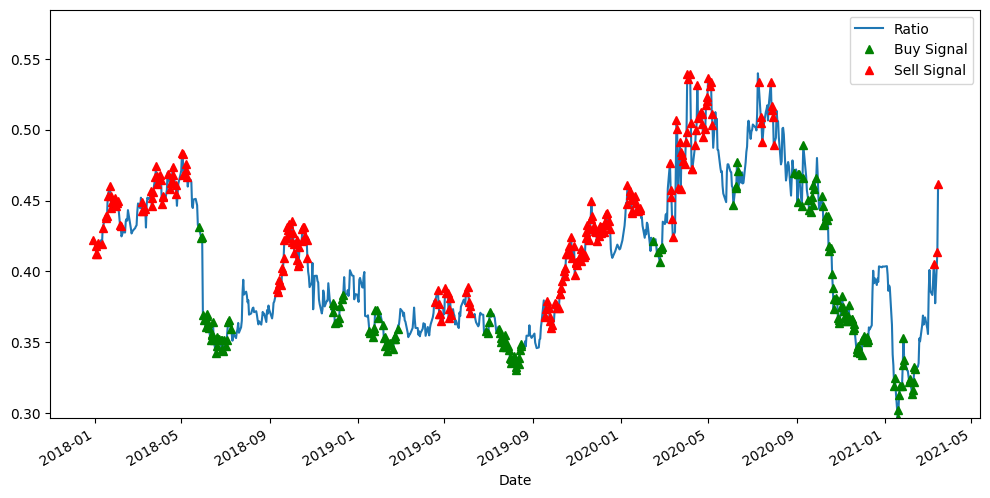

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
train[250:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[250:].plot(color='green',linestyle='None',marker='^')
sell[250:].plot(color='red',linestyle='None',marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratio.min(),ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

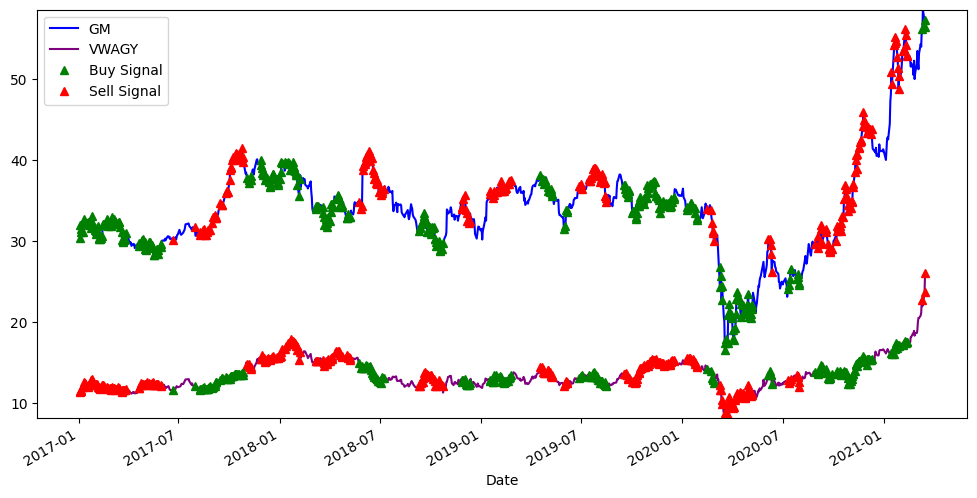

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
s1 = df['GM'].iloc[:1057]
s2 = df['VWAGY'].iloc[:1057]
s1.plot(color='blue')
s2.plot(color='purple')
buyR = 0*s1.copy()
sellR = 0*s2.copy()

# buy the ratio
buyR[buy!=0] = s2[buy!=0]
sellR[buy!=0] = s1[buy!=0]

# sell the ratio
buyR[sell!=0] = s1[sell!=0]
sellR[sell!=0] = s2[sell!=0]

buyR.plot(color='green',linestyle='None', marker='^')
sellR.plot(color='red',linestyle='None',marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(s1.min(), s2.min()), max(s1.max(), s2.max())))

plt.legend(['GM', 'VWAGY', 'Buy Signal', 'Sell Signal'])
plt.show()

In [ ]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [ ]:
# Define the range of values for window1 and window2 to search
window1_range = range(1, 150)  # Adjust the range as needed
window2_range = range(1, 150)  # Adjust the range as needed

best_money = -np.inf  # Initialize the best money earned to negative infinity
best_window1 = None
best_window2 = None

# Iterate through all combinations of window1 and window2
for window1 in window1_range:
    for window2 in window2_range:
        money = trade(df['GM'].iloc[1057:],df['VWAGY'].iloc[1057:], window1, window2)
        if money > best_money:
            best_money = money
            best_window1 = window1
            best_window2 = window2

print(f"Best Money: {best_money}")
print(f"Best window1: {best_window1}")
print(f"Best window2: {best_window2}")


Best Money: 1011.0172550690467
Best window1: 118
Best window2: 2


In [ ]:
trade(df['GM'].iloc[1057:],df['VWAGY'].iloc[1057:],60,5)

473.1561721676563

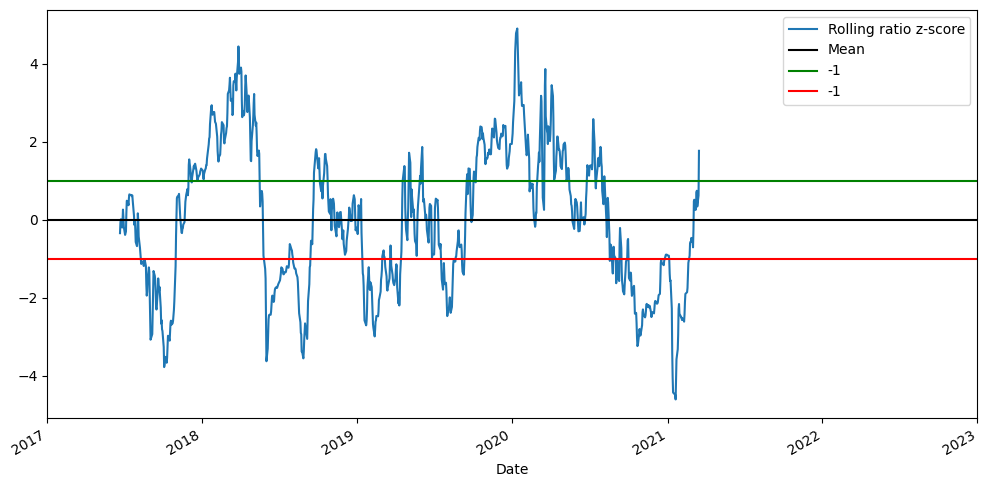

In [ ]:
#considering weekly moving average
ma5_ratio = train.rolling(window=2,center=False).mean()
#3 month moving average
ma60_ratio = train.rolling(window=118,center=False).mean()
#standard deviation of 60 days
std_60 = train.rolling(window=60,center=False).std()
zscore_60_5 = (ma5_ratio - ma60_ratio)/std_60

plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.axhline(0,color='black')
plt.axhline(1.0,color='green')
plt.axhline(-1.0,color='red')
plt.xlim('2017-01-01','2023-01-01')
plt.legend(['Rolling ratio z-score','Mean','-1','-1'])
plt.show()